# Result analysis

## Setting up the kernel

In [142]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns


from rich import print
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from scipy.stats import qmc
from scipy.interpolate import interp1d
from scipy.stats import linregress


In [2]:
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle_DA import DA

## Loading in needed functions

In [3]:
from Drought_Function import analyse_annual_deficits_MW

In [4]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must be converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

## Defining the experiment dates and file paths

In [5]:
# Defining the data period
start_historic = '1986-11-01'
end_historic = '2014-10-31'

future_data_start = '2026-11-01'
future_data_end = '2099-10-31' 

In [60]:
# defining path for catchment shape file
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

# defining destination path for CMIP data
CMIP_folder = Path.home() / "CMIP"
CMIP_folder.mkdir(exist_ok=True)

# model HBV destination path
HBV_model_path = Path.home() / "HBV_model" / "CMIP"
HBV_model_path.mkdir(exist_ok=True)

# Loading in CMIP6 forcings
CMIP_historic = CMIP_folder / "scen_historic" / "work" / "diagnostic" / "script" 
historic = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_historic)

CMIP_119 = CMIP_folder / "scen_119" / "work" / "diagnostic" / "script" 
SSP119 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_119)

CMIP_126 = CMIP_folder / "scen_126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_126)

CMIP_245 = CMIP_folder / "scen_245" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_245)

CMIP_370 = CMIP_folder / "scen_370" / "work" / "diagnostic" / "script" 
SSP370 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_370)

CMIP_585 = CMIP_folder / "scen_585" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_585)

## Loading in observed data

In [41]:
# Loading in discharge data from the measuring station Katima Mulilo
km = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
      .drop(columns=['hh:mm'])
      .rename(columns={'YYYY-MM-DD': 'Date', ' Value': 'Discharge [m^3/s]'}))

# Removing nans
km['Discharge [m^3/s]'] = km['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Adjusting the data-set to datetime format
km['Date'] = pd.to_datetime(km['Date'])
km['Year'] = km['Date'].dt.year
km['Day'] = km['Date'].dt.dayofyear

# Defining the data period
start_calibration = '1986-11-01'
end_calibration = '2019-10-31'
start_hydro_year = 1987
end_hydro_year = 2019

# Reducing the dataframe to the calibration period
km = km[(km['Date'] >= start_calibration) & (km['Date'] <= end_calibration)]
km['hydro_year'] = np.where(km['Day'] < 305, km['Year'], km['Year'] + 1)


## Giving the input parameters

In [8]:
# Applying the parameters found in the KGE model fit calibration
params_KGE = [5.65179127, 0.27593564, 779.15056566, 2.45298864, 0.04682875, 1.3263829, 0.01356608, 0.0070803, 0.48990002]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

## Running the HBV model for each scenario

In [ ]:
forcing_list = [historic, SSP119, SSP126, SSP245, SSP370, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(parameters=params_KGE, initial_storage=s_0, cfg_dir=HBV_model_path)

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

## Running the drought analyser per scenario

In [10]:
historic_output = mmday_to_m3s(pd.DataFrame(data=output[0], index=years[0], columns=['Q']), catchment_area_km2)[start_historic : end_historic]
SSP119_output = mmday_to_m3s(pd.DataFrame(data=output[1], index=years[1], columns=['Q']), catchment_area_km2)[future_data_start : future_data_end]
SSP126_output = mmday_to_m3s(pd.DataFrame(data=output[2], index=years[2], columns=['Q']), catchment_area_km2)[future_data_start : future_data_end]
SSP245_output = mmday_to_m3s(pd.DataFrame(data=output[3], index=years[3], columns=['Q']), catchment_area_km2)[future_data_start : future_data_end]
SSP370_output = mmday_to_m3s(pd.DataFrame(data=output[4], index=years[4], columns=['Q']), catchment_area_km2)[future_data_start : future_data_end]
SSP585_output = mmday_to_m3s(pd.DataFrame(data=output[5], index=years[5], columns=['Q']), catchment_area_km2)[future_data_start : future_data_end]

In [120]:
# Put your existing DataFrames into a dictionary
ssp_dfs = {'historic' : historic_output, 'SSP119': SSP119_output, 'SSP126': SSP126_output, 'SSP245': SSP245_output, 'SSP370': SSP370_output,  'SSP585': SSP585_output}

# Process each one
for label, df in ssp_dfs.items():
    df = df.copy()
    df = df.reset_index().rename(columns={'index': 'Date'})
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Day'] = df['Date'].dt.dayofyear
    df['hydro_year'] = np.where(df['Day'] < 305, df['Year'], df['Year'] + 1)
    
    ssp_dfs[label] = df

def_hist = analyse_annual_deficits_MW(ssp_dfs['historic'], 'Q', 'hydro_year', 1466.820, 730, 760)
def_119 = analyse_annual_deficits_MW(ssp_dfs['SSP119'], 'Q', 'hydro_year', 1466.820, 730, 760)
def_126 = analyse_annual_deficits_MW(ssp_dfs['SSP126'], 'Q', 'hydro_year', 1466.820, 730, 760)
def_245 = analyse_annual_deficits_MW(ssp_dfs['SSP245'], 'Q', 'hydro_year', 1466.820, 730, 760)
def_370 = analyse_annual_deficits_MW(ssp_dfs['SSP370'], 'Q', 'hydro_year', 1466.820, 730, 760)
def_585 = analyse_annual_deficits_MW(ssp_dfs['SSP585'], 'Q', 'hydro_year', 1466.820, 730, 760)

## Result analysis

### Drought distribution function

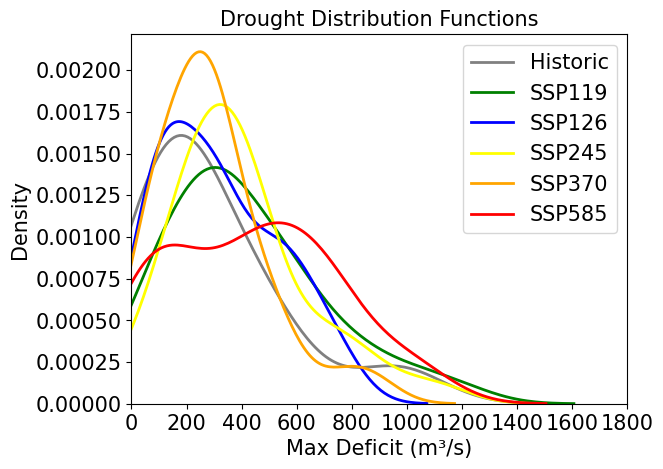

In [168]:
sns.kdeplot(def_hist['avg_net_deficit_m^3/s'], label='Historic', color="gray", linewidth=2)
sns.kdeplot(def_119['avg_net_deficit_m^3/s'], label='SSP119', color="green", linewidth=2)
sns.kdeplot(def_126['avg_net_deficit_m^3/s'], label='SSP126', color="blue", linewidth=2)
sns.kdeplot(def_245['avg_net_deficit_m^3/s'], label='SSP245', color="yellow", linewidth=2)
sns.kdeplot(def_370['avg_net_deficit_m^3/s'], label='SSP370', color="orange", linewidth=2)
sns.kdeplot(def_585['avg_net_deficit_m^3/s'], label='SSP585', color="red", linewidth=2)

plt.title('Drought Distribution Functions',fontsize=15)
plt.xlim(0, 1800)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Max Deficit (m³/s)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=15)

### Drought cumulative distribution function

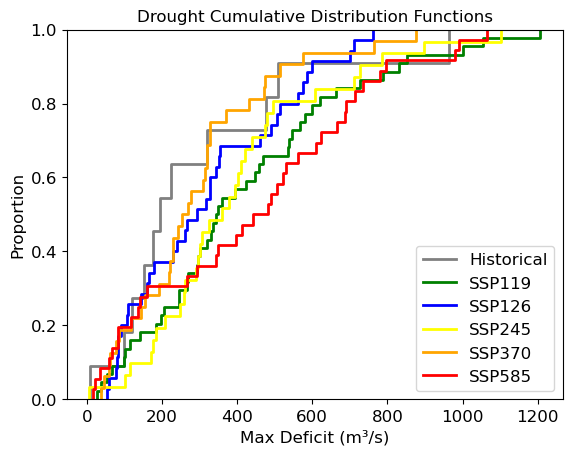

In [169]:
# Plot 2: Deficit
sns.ecdfplot(def_hist['avg_net_deficit_m^3/s'], label='Historical', color="gray", linewidth=2)
sns.ecdfplot(def_119['avg_net_deficit_m^3/s'], label='SSP119', color="green", linewidth=2)
sns.ecdfplot(def_126['avg_net_deficit_m^3/s'], label='SSP126', color="blue", linewidth=2)
sns.ecdfplot(def_245['avg_net_deficit_m^3/s'], label='SSP245', color="yellow", linewidth=2)
sns.ecdfplot(def_370['avg_net_deficit_m^3/s'], label='SSP370', color="orange", linewidth=2)
sns.ecdfplot(def_585['avg_net_deficit_m^3/s'], label='SSP585', color="red", linewidth=2)


plt.title('Drought Cumulative Distribution Functions')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Max Deficit (m³/s)', fontsize=12)
plt.legend(fontsize=12)

## Return period

### Inital Return Periods

In [123]:
def plot_return_period(data, years, color, label):
    sorted_data = np.sort(data)
    N = years
    n = len(sorted_data)

    # Emperical cumulative distribution
    F = np.arange(1, n + 1) / (n + 1)

    # Return Period
    return_period = N / (n * (1 - F))

    # Plot
    plt.scatter(return_period, sorted_data, color=color, alpha=0.5, label=label)

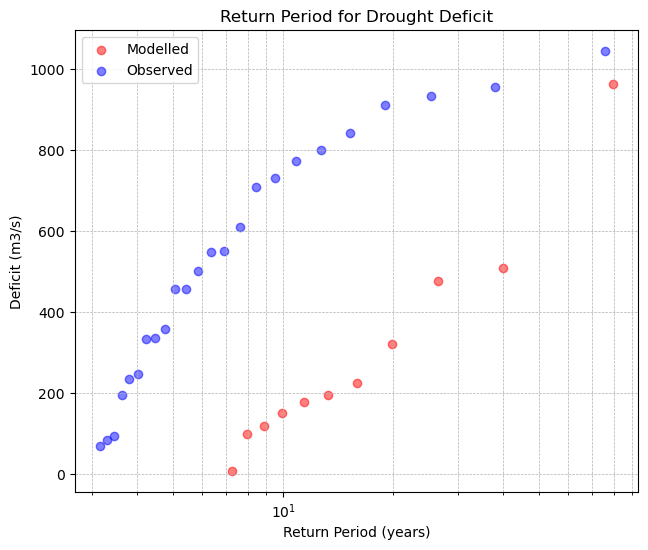

In [124]:
def_hist_obs = analyse_annual_deficits_MW(km, 'Discharge [m^3/s]', 'hydro_year', 1466.820, 730, 760)
def_hist_CMIP = analyse_annual_deficits_MW(ssp_dfs['historic'], 'Q', 'hydro_year', 1466.820, 730, 760)

# Plot the return periods for observed and cmip historical data
plt.figure(figsize=(16, 6))

CF = 1.0
plt.subplot(1, 2, 2)
plot_return_period(def_hist_CMIP['avg_net_deficit_m^3/s']*CF, 73, "red", "Modelled")
plot_return_period(def_hist_obs['avg_net_deficit_m^3/s'], 73, "blue", "Observed")

plt.xscale('log')
plt.title('Return Period for Drought Deficit')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m3/s)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

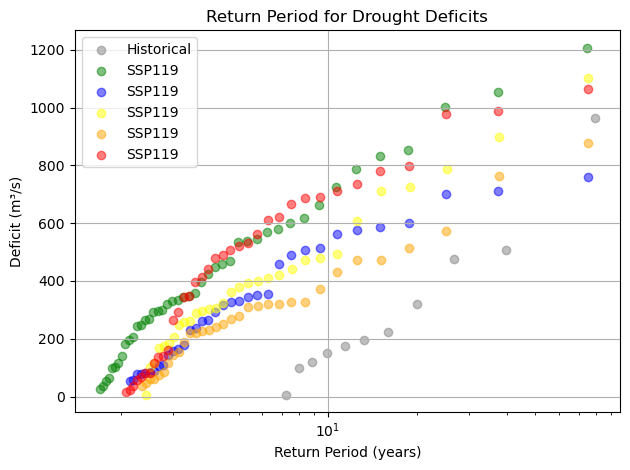

In [166]:
plot_return_period(def_hist['avg_net_deficit_m^3/s'], 73, 'gray', 'Historical')
plot_return_period(def_119['avg_net_deficit_m^3/s'], 73, 'green', 'SSP119')
plot_return_period(def_126['avg_net_deficit_m^3/s'], 73, 'blue', 'SSP119')
plot_return_period(def_245['avg_net_deficit_m^3/s'], 73, 'yellow', 'SSP119')
plot_return_period(def_370['avg_net_deficit_m^3/s'], 73, 'orange', 'SSP119')
plot_return_period(def_585['avg_net_deficit_m^3/s'], 73, 'red', 'SSP119')

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m³/s)')
plt.title('Return Period for Drought Deficits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Corrected Return Periods (Quantile mapping)

In [137]:
def quantile_mapping(obs_deficit, mod_deficit):
    # Define a common quantile grid (e.g., 1000 points between 0 and 1)
    quantiles = np.linspace(0, 1, 1000)

    # Sort the data
    sorted_obs = np.sort(obs_deficit)
    sorted_mod = np.sort(mod_deficit)

    # Interpolate both series onto the common quantile grid
    obs_interp = interp1d(np.linspace(0, 1, len(sorted_obs)), sorted_obs, bounds_error=False, fill_value="extrapolate")
    mod_interp = interp1d(np.linspace(0, 1, len(sorted_mod)), sorted_mod, bounds_error=False, fill_value="extrapolate")

    obs_on_quantiles = obs_interp(quantiles)
    mod_on_quantiles = mod_interp(quantiles)

    # Create mapping from modelled deficits to observed using interpolation
    mapping_function = interp1d(mod_on_quantiles, obs_on_quantiles, bounds_error=False, fill_value="extrapolate")

    return mapping_function


In [138]:
def compute_return_periods(deficits):
    sorted_deficits = np.sort(deficits)[::-1]
    ranks = np.arange(1, len(sorted_deficits) + 1)
    return_periods = (len(sorted_deficits) + 1) / ranks
    return return_periods, sorted_deficits

In [139]:
def_hist_obs = analyse_annual_deficits_MW(km, 'Discharge [m^3/s]', 'hydro_year', 1466.820, 730, 760)

In [140]:
# Create the function
qm_func = quantile_mapping(def_hist_obs['avg_net_deficit_m^3/s'], def_hist['avg_net_deficit_m^3/s'])

# Apply to modelled deficits
def_hist['Corrected Deficit'] = qm_func(def_hist['avg_net_deficit_m^3/s'])
def_119['Corrected Deficit'] = qm_func(def_119['avg_net_deficit_m^3/s'])
def_126['Corrected Deficit'] = qm_func(def_126['avg_net_deficit_m^3/s'])
def_245['Corrected Deficit'] = qm_func(def_245['avg_net_deficit_m^3/s'])
def_370['Corrected Deficit'] = qm_func(def_370['avg_net_deficit_m^3/s'])
def_585['Corrected Deficit'] = qm_func(def_585['avg_net_deficit_m^3/s'])

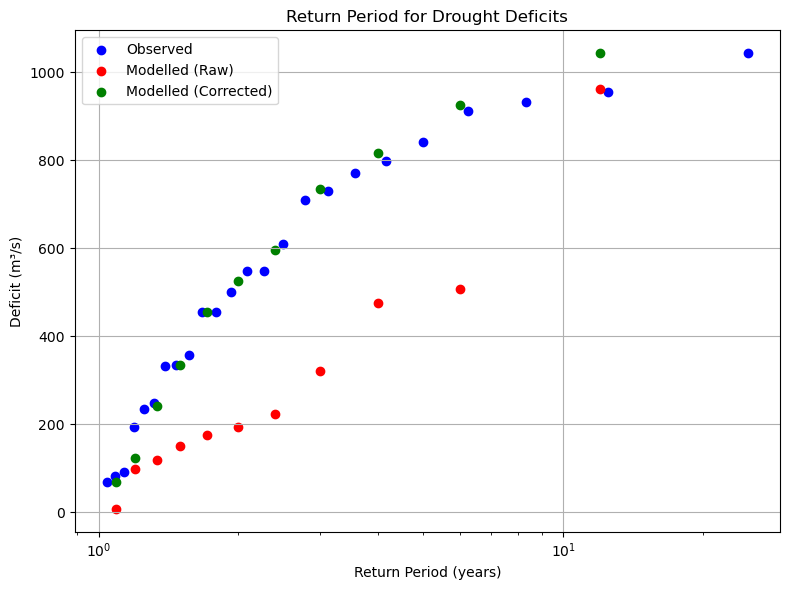

In [149]:
# Compute return periods
rp_obs, d_obs = compute_return_periods(def_hist_obs['avg_net_deficit_m^3/s'])
rp_mod, d_mod = compute_return_periods(def_hist['avg_net_deficit_m^3/s'])
rp_corr, d_corr = compute_return_periods(def_hist['Corrected Deficit'])

# Plot
plt.figure(figsize=(8,6))
plt.scatter(rp_obs, d_obs, label='Observed', color='blue')
plt.scatter(rp_mod, d_mod, label='Modelled (Raw)', color='red')
plt.scatter(rp_corr, d_corr, label='Modelled (Corrected)', color='green')

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m³/s)')
plt.title('Return Period for Drought Deficits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


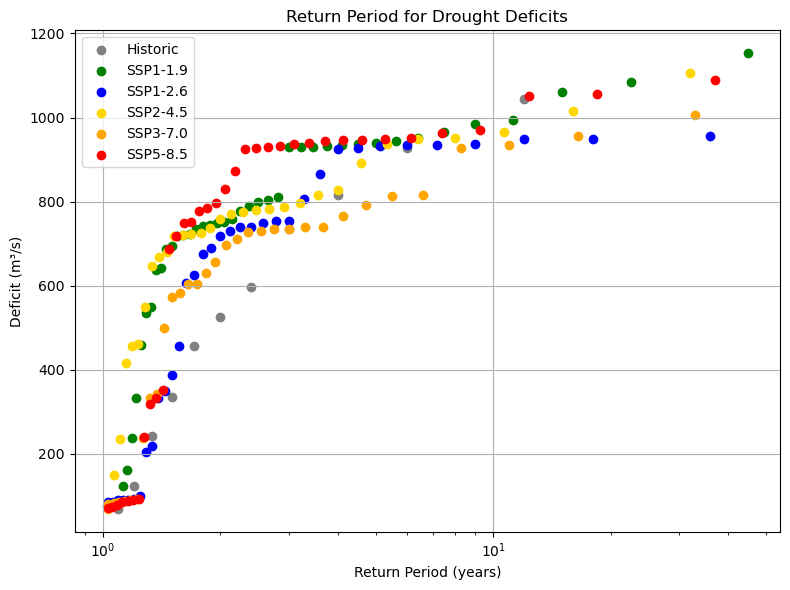

In [167]:
# Compute return periods
# rp_119, d_119 = compute_return_periods(def_119['avg_net_deficit_m^3/s'])
rp_119_c, d_119_c = compute_return_periods(def_119['Corrected Deficit'])

# rp_126, d_126 = compute_return_periods(def_126['avg_net_deficit_m^3/s'])
rp_126_c, d_126_c = compute_return_periods(def_126['Corrected Deficit'])

# rp_245, d_245 = compute_return_periods(def_245['avg_net_deficit_m^3/s'])
rp_245_c, d_245_c = compute_return_periods(def_245['Corrected Deficit'])

# rp_370, d_370 = compute_return_periods(def_370['avg_net_deficit_m^3/s'])
rp_370_c, d_370_c = compute_return_periods(def_370['Corrected Deficit'])

# rp_585, d_585 = compute_return_periods(def_585['avg_net_deficit_m^3/s'])
rp_585_c, d_585_c = compute_return_periods(def_585['Corrected Deficit'])

plt.figure(figsize=(8,6))

plt.scatter(rp_corr, d_corr, label='Historic', color='gray')

# plt.scatter(rp_119, d_119, label='SSP1-1.9 (Raw)', color='lightcoral')
plt.scatter(rp_119_c, d_119_c, label='SSP1-1.9', color='green')

# plt.scatter(rp_126, d_126, label='SSP1-2.6 (Raw)', color='gold')
plt.scatter(rp_126_c, d_126_c, label='SSP1-2.6', color='blue')

# plt.scatter(rp_245, d_245, label='SSP2-4.5 (Raw)', color='darkseagreen')
plt.scatter(rp_245_c, d_245_c, label='SSP2-4.5', color='gold')

# plt.scatter(rp_370, d_370, label='SSP3-7.0 (Raw)', color='teal')
plt.scatter(rp_370_c, d_370_c, label='SSP3-7.0', color='orange')

# plt.scatter(rp_585, d_585, label='SSP5-5.8 (Raw)', color='darkmagenta')
plt.scatter(rp_585_c, d_585_c, label='SSP5-8.5', color='red')

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m³/s)')
plt.title('Return Period for Drought Deficits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
